In [1]:
# Importando as bibliotecas necessárias
!pip install control
import control as ct
import numpy as np
import matplotlib.pyplot as plt

# Configurações para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 6.2 MB/s eta 0:00:00


--- Simulação 1: Compensação de Avanço (Lead) ---
Sistema Original: Oscilatório e lento.


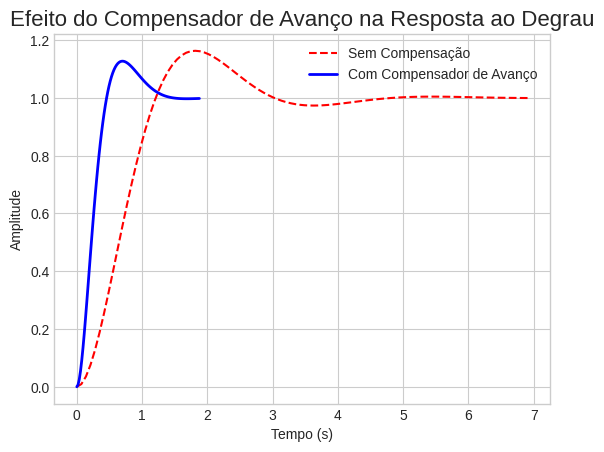


ANÁLISE:
- O sistema compensado é muito mais rápido (menor tempo de subida).
- O overshoot foi reduzido significativamente.
- O compensador 'adiantou' a fase, permitindo ganhos maiores com estabilidade.


In [2]:
# --- Bloco de Código 1: Projeto de Compensador de Avanço (Lead) ---
# Objetivo: Melhorar a resposta transitória (velocidade e overshoot)

print("--- Simulação 1: Compensação de Avanço (Lead) ---")

# 1. Sistema Não Compensado (Lento e oscilatório)
# G(s) = 4 / [s(s+2)]
sys_planta = ct.tf([4], [1, 2, 0])

# Verificando desempenho original
t_orig, y_orig = ct.step_response(ct.feedback(sys_planta, 1))
print("Sistema Original: Oscilatório e lento.")

# 2. Projeto do Compensador de Avanço
# Queremos puxar o LGR para a esquerda para aumentar o amortecimento (zeta).
# Vamos colocar um ZERO em s=-3 (para cancelar parte do efeito dos polos lentos)
# e um POLO em s=-10 (bem longe, para não atrapalhar a fase).
# Gc(s) = K * (s + 3) / (s + 10)
z_lead = 3
p_lead = 10
K_lead = 10 # Ganho ajustado para manter a magnitude correta

sys_lead_comp = ct.tf([K_lead, K_lead*z_lead], [1, p_lead]) # 10(s+3)/(s+10)

# Sistema em Malha Aberta Compensado: L(s) = Gc(s)*G(s)
sys_open_loop_comp = sys_lead_comp * sys_planta

# Sistema em Malha Fechada Compensado
sys_closed_loop_comp = ct.feedback(sys_open_loop_comp, 1)

# 3. Comparação das Respostas ao Degrau
t_comp, y_comp = ct.step_response(sys_closed_loop_comp)

plt.figure()
plt.plot(t_orig, y_orig, label='Sem Compensação', linestyle='--', color='red')
plt.plot(t_comp, y_comp, label='Com Compensador de Avanço', linewidth=2, color='blue')
plt.title('Efeito do Compensador de Avanço na Resposta ao Degrau', fontsize=16)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

print("\nANÁLISE:")
print("- O sistema compensado é muito mais rápido (menor tempo de subida).")
print("- O overshoot foi reduzido significativamente.")
print("- O compensador 'adiantou' a fase, permitindo ganhos maiores com estabilidade.")


--- Simulação 2: Compensação de Atraso (Lag) ---


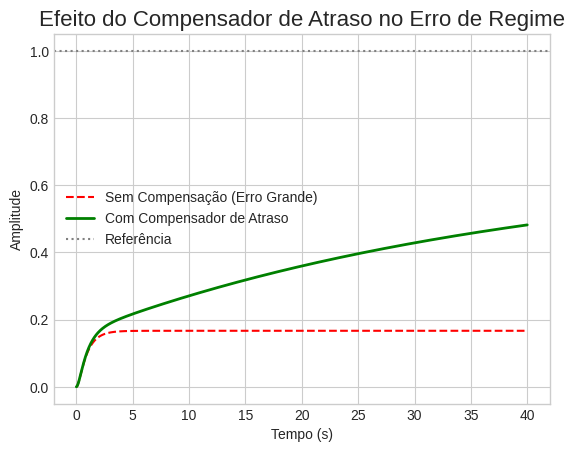


ANÁLISE:
- Erro Estacionário Original: 83.33%
- Erro Estacionário Compensado: 51.82%
- O compensador de atraso aumentou o ganho da malha em baixas frequências,
  forçando a saída a ficar muito mais próxima da referência (1.0).
- Note que a velocidade da resposta (transiente) quase não mudou.


In [3]:
# --- Bloco de Código 2: Projeto de Compensador de Atraso (Lag) ---
# Objetivo: Melhorar o erro em regime estacionário (precisão)

print("\n--- Simulação 2: Compensação de Atraso (Lag) ---")

# 1. Sistema Original (Estável, mas com erro de regime)
# G(s) = 1 / [(s+1)(s+5)]
# Para uma entrada degrau, o ganho DC é 1/5 = 0.2.
# Erro = 1 - T(0). T(0) = 0.2 / (1+0.2) = 0.16. Erro enorme de ~83%.
sys_planta_lag = ct.tf([1], [1, 6, 5])

# 2. Projeto do Compensador de Atraso
# Queremos aumentar o ganho em baixa frequência por um fator de 10,
# sem alterar o comportamento em alta frequência (onde a estabilidade é decidida).
# Escolhemos z/p = 10. O polo deve estar MUITO perto da origem.
# Zero em s = -0.1, Polo em s = -0.01
z_lag = 0.1
p_lag = 0.01
K_lag = 1 # Ganho unitário em alta frequência

# Gc(s) = (s + 0.1) / (s + 0.01)
# Em alta freq (s->inf), ganho -> 1. Em baixa freq (s->0), ganho -> 10.
sys_lag_comp = ct.tf([1, z_lag], [1, p_lag])

# Malhas Fechadas
sys_cl_orig = ct.feedback(sys_planta_lag, 1)
sys_cl_comp = ct.feedback(sys_lag_comp * sys_planta_lag, 1)

# 3. Comparação
t_lag, y_lag_orig = ct.step_response(sys_cl_orig, T=np.linspace(0, 40, 1000))
t_lag, y_lag_comp = ct.step_response(sys_cl_comp, T=np.linspace(0, 40, 1000))

plt.figure()
plt.plot(t_lag, y_lag_orig, label='Sem Compensação (Erro Grande)', linestyle='--', color='red')
plt.plot(t_lag, y_lag_comp, label='Com Compensador de Atraso', linewidth=2, color='green')
plt.title('Efeito do Compensador de Atraso no Erro de Regime', fontsize=16)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.axhline(1, color='gray', linestyle=':', label='Referência')
plt.legend()
plt.grid(True)
plt.show()

# Cálculo dos Erros Finais
erro_orig = 1 - y_lag_orig[-1]
erro_comp = 1 - y_lag_comp[-1]

print(f"\nANÁLISE:")
print(f"- Erro Estacionário Original: {erro_orig*100:.2f}%")
print(f"- Erro Estacionário Compensado: {erro_comp*100:.2f}%")
print("- O compensador de atraso aumentou o ganho da malha em baixas frequências,")
print("  forçando a saída a ficar muito mais próxima da referência (1.0).")
print("- Note que a velocidade da resposta (transiente) quase não mudou.")